Project: Machine Learning of Salary and Demographic Factors
Name: Shaohua Feng

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
# import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

In [ ]:
# from sklearn.metrics import plot_confusion_matrix doesn't work, so
!pip install plot_confusion_matrix

In [ ]:
#######################################
## Read data and data wrangling
#######################################
# read in data loaded in google drive
file_path_1 = '/content/drive/My Drive/adult.data'
adult_1= pd.read_csv(file_path_1,header=None)
file_path_2 = '/content/drive/My Drive/adult.test.txt'
adult_2= pd.read_csv(file_path_2,header=None)
adult=pd.concat([adult_1, adult_2], ignore_index=True)

In [ ]:
# add column names

cols=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
adult.columns=cols

# add y column to data frame. target=1 for label '>50k' and y=0 for label '<=50k'
adult['target']=np.where(adult['label']==' >50K',1,0)
#adult['target'] = adult['target'].astype(bool)
#
#print(adult.describe())
#adult.dtypes
#adult.info()

In [ ]:
# Data Manipulation: replace '?' with None
adult['workclass']=adult['workclass'].replace(' ?',None)
adult['occupation']=adult['occupation'].replace(' ?',None)
adult['native-country']=adult['native-country'].replace(' ?',None)

In [ ]:
# charactegorical columns
cols_cat=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']

for x in cols_cat:
  adult[x] = adult[x].astype('category')
  #print(x)

adult.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
label               object
target               int64
dtype: object

In [ ]:
# delete missing value
adult_new=adult.dropna()
print(len(adult_new))

45222


In [ ]:
# drop original label
del adult_new['label']
# adult_new.head(5)

In [ ]:
# Function to remove outliers from based on z-score
def remove_outliers(df, columns, threshold=3):
    z_scores = stats.zscore(df[columns])
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    df_cleaned = df[filtered_entries]
    return df_cleaned

In [ ]:
# remove outliers
numerical_cols = ['age','fnlwgt', 'education-num', 'capital-gain','capital-loss','hours-per-week']

# Remove outliers from the specified columns
adult_cleaned = remove_outliers(adult_new, numerical_cols)

print("Size of cleaned data ",len(adult_cleaned))

Size of cleaned data  41395


In [ ]:
############################
# Functions used by the machine learning algorithms
#Normalizing numeric data
def normalize(x):
  if x.dtype == 'int' or x.dtype == 'float':
    return ((x - min(x)) / (max(x) - min(x)))
  else:
    return x

In [ ]:
#Function to convert categorical data to dummmy/one-hot variables
def dummy(x):
  cat_col=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
  x = pd.get_dummies(x, columns=cat_col, prefix = cat_col)
  return x
#print the dataset
#adult_new.head(5)


In [ ]:
# Print out Accuracy
def printAcc(y_test,y_pred):
  from sklearn.metrics import accuracy_score

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")

In [ ]:
# print out confusion matrix
def printConfusion(y_test, y_pred):

  from sklearn.metrics import confusion_matrix

  cf=confusion_matrix(y_test, y_pred)
  print(cf)
  tn, fp, fn, tp=cf.ravel()
  print ("TP: ", tp,", FP: ", fp,", TN: ", tn,", FN:", fn)

In [ ]:
#print precision, recall, and accuracy from the perspective of each of the class (0 and 1 for Adult dataset)
def printReport(y_test,y_pred):

  from sklearn.metrics import classification_report
  from sklearn import metrics

  print(classification_report(y_test, y_pred))

In [ ]:
#################################################
# Decision tree
#################################################

# Decision tree without oversampling and normalization
# I want to use it as baseline to proof that oversampling and normalization improves decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a deep copy of the data frame adult_cleaned and name it adult_new
# adult_new is not normalized or oversampled
# I will use adult_new as the base line
adult_dt_noNormal=adult_cleaned.copy(deep=True)

#X = list(set(list(adult_cleaned)) - set(['target']))
X = adult_dt_noNormal.drop('target', axis=1)
y = adult_dt_noNormal['target']

# dummy variable
X=dummy(X)

# split train and test. test size is 0.35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=52)

# create decision tree classifier
dtc = DecisionTreeClassifier(random_state=52,max_depth=5)
# Train the model on the training data
dtc.fit(X_train, y_train)
# Make predictions on the test data
y_pred = dtc.predict(X_test)

print("Decision Tree for data without normalization and oversampling")
# Print Accuracy
printAcc(y_test,y_pred)

# Print Confusion Matrix
print("")
print("Confustion Matrix")
printConfusion(y_test, y_pred)

# Print Diagnosis
print("")
printReport(y_test,y_pred)



Decision Tree for data without normalization and oversampling
Accuracy: 0.8593415694664919

Confustion Matrix
[[11838   398]
 [ 1640   613]]
TP:  613 , FP:  398 , TN:  11838 , FN: 1640

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     12236
           1       0.61      0.27      0.38      2253

    accuracy                           0.86     14489
   macro avg       0.74      0.62      0.65     14489
weighted avg       0.84      0.86      0.84     14489



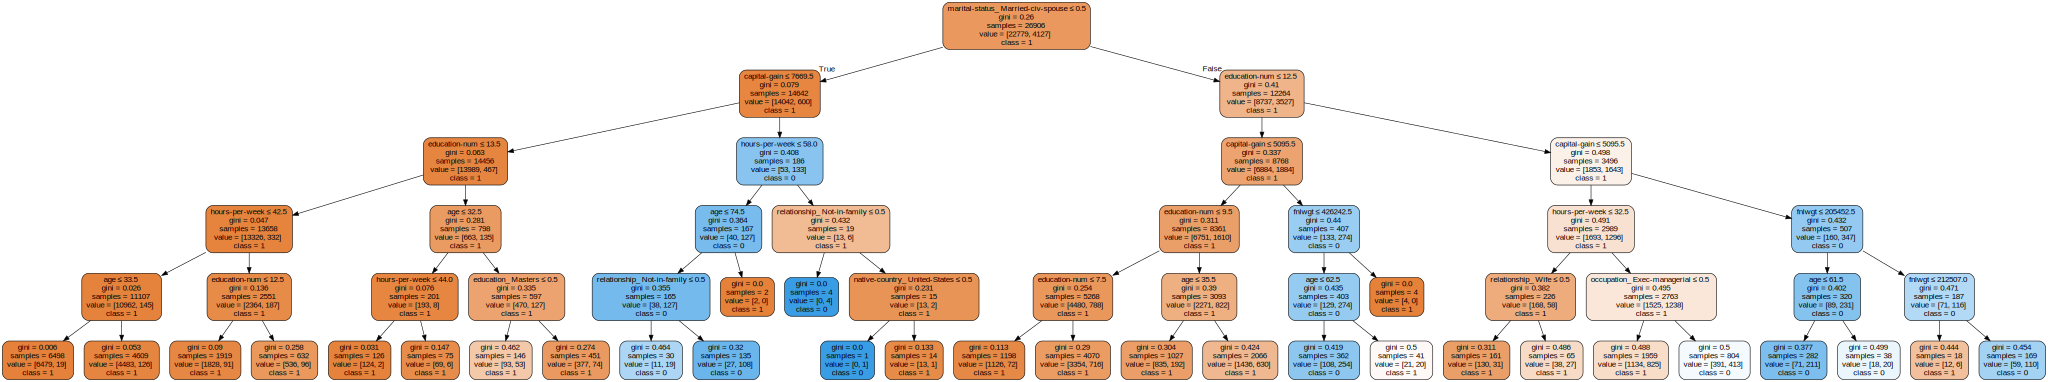

In [ ]:
# plot decision tree without normalization
import graphviz

# Export decision tree to Graphviz format
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names=X.columns,
                                class_names=['1', '0'],  # Assuming binary classification, replace with actual class names
                                filled=True, rounded=True, special_characters=True)

# Plot tree
graph = graphviz.Source(dot_data, format="png")
graph.render("decisionTree_no_normal")  # Save the plot as 'decision_tree.png' (you can change the filename)

# Display the tree plot
graph




In [ ]:
# Decision tree with normalization but no oversampling

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a deep copy of the data frame adult_cleaned and name it adult_new
# adult_new is not normalized or oversampled
# I will use adult_new as the base line
adult_dt_norm = adult_cleaned.copy(deep=True)
X = adult_dt_norm.drop('target', axis=1)
y = adult_dt_norm['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
# why this code doesn't work?
#X[num_cols] = X[num_cols].apply(lambda x:normalize(x), axis=0)
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

#print(X.head(5))
#print(X.tail(5))
# dummy variable
X=dummy(X)

# split train and test. test size is 0.35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=52)

# create decision tree classifier
dtc_norm = DecisionTreeClassifier(random_state=52)
# Train the model on the training data
dtc_norm.fit(X_train, y_train)
# Make predictions on the test data
y_pred = dtc_norm.predict(X_test)

print("Decision Tree for data with normalization but no oversampling")
# Print Accuracy
printAcc(y_test,y_pred)

# Print Confusion Matrix
print("")
print("Confustion Matrix")
printConfusion(y_test, y_pred)

# Print Diagnosis
print("")
printReport(y_test,y_pred)






Decision Tree for data with normalization but no oversampling
Accuracy: 0.8057836979777763

Confustion Matrix
[[10784  1452]
 [ 1362   891]]
TP:  891 , FP:  1452 , TN:  10784 , FN: 1362

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12236
           1       0.38      0.40      0.39      2253

    accuracy                           0.81     14489
   macro avg       0.63      0.64      0.64     14489
weighted avg       0.81      0.81      0.81     14489



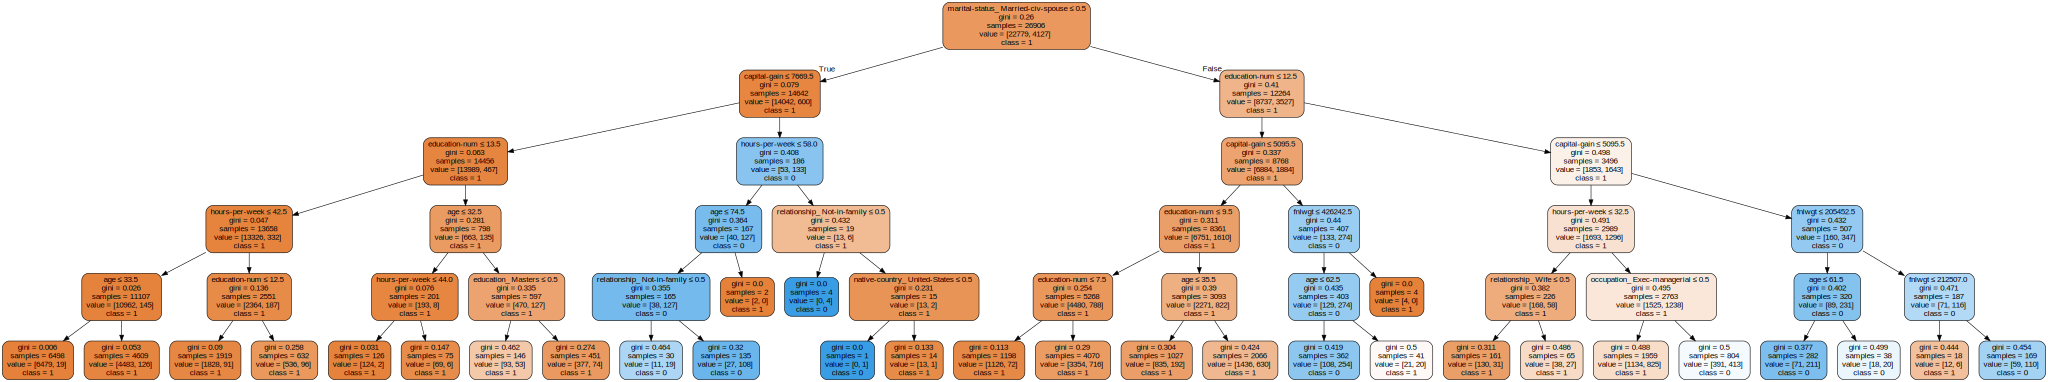

In [ ]:
# plot decision tree with normalization but no oversampling
import graphviz

# Export decision tree to Graphviz format
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names=X.columns,
                                class_names=['1', '0'],  # Assuming binary classification, replace with actual class names
                                filled=True, rounded=True, special_characters=True)

# Plot tree
graph = graphviz.Source(dot_data, format="png")
graph.render("decisionTree_normal")  # Save the plot as 'decision_tree.png' (you can change the filename)

# Display the tree plot
graph


In [ ]:
# Decision tree with normalization and random oversampling
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Create a deep copy of the data frame adult_dt_norm_ros
# X is normalized and random oversampled
adult_dt_norm_ros = adult_cleaned.copy(deep=True)
X = adult_dt_norm_ros.drop('target', axis=1)
y = adult_dt_norm_ros['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy variable
X=dummy(X)

# split train and test. test size is 0.35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=52)

#Random Oversampling
ros = RandomOverSampler(sampling_strategy='auto', random_state=52)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# create decision tree classifier for normalized data with random oversampling
dtc_norm_ros = DecisionTreeClassifier(random_state=52)
# Train the model on the training data
dtc_norm.fit(X_train_ros, y_train_ros)
# Make predictions on the test data
y_pred = dtc_norm.predict(X_test)

print("Decision Tree for data with normalization and random oversampling")
# Print Accuracy
printAcc(y_test,y_pred)

# Print Confusion Matrix
print("")
print("Confustion Matrix")
printConfusion(y_test, y_pred)

# Print Diagnosis
print("")
printReport(y_test,y_pred)

Decision Tree for data with normalization and random oversampling
Accuracy: 0.8125474497894954

Confustion Matrix
[[10878  1358]
 [ 1358   895]]
TP:  895 , FP:  1358 , TN:  10878 , FN: 1358

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12236
           1       0.40      0.40      0.40      2253

    accuracy                           0.81     14489
   macro avg       0.64      0.64      0.64     14489
weighted avg       0.81      0.81      0.81     14489



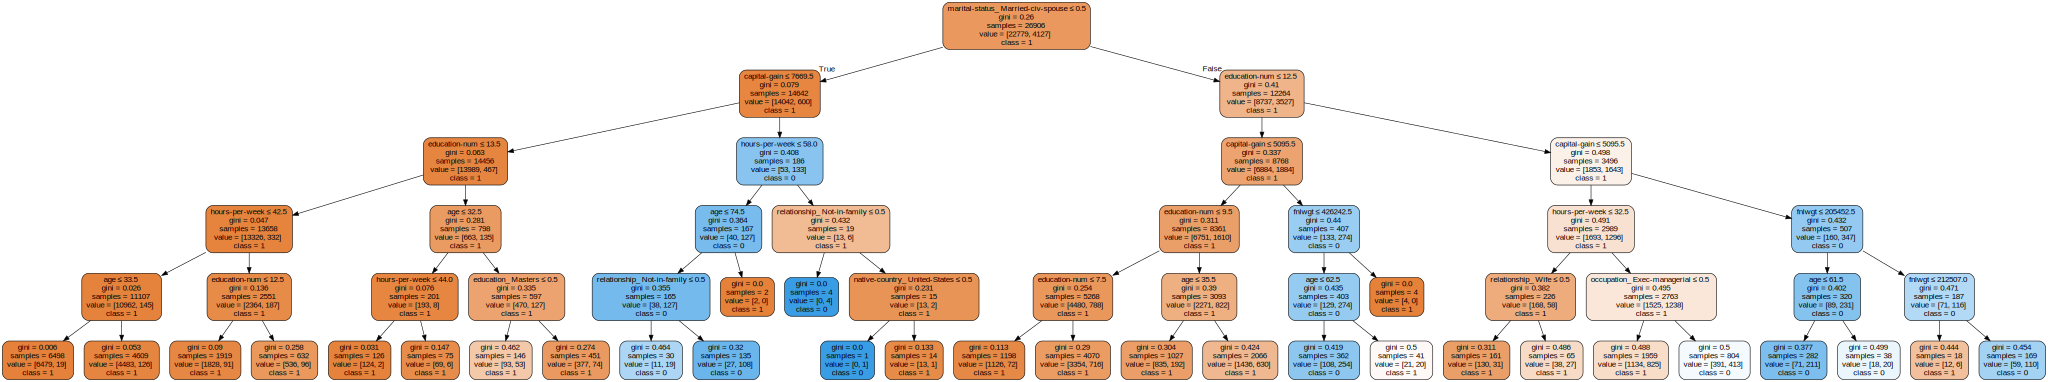

In [ ]:
# plot decision tree with normalization and oversampling
import graphviz

# Export decision tree to Graphviz format
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names=X.columns,
                                class_names=['1', '0'],  # Assuming binary classification, replace with actual class names
                                filled=True, rounded=True, special_characters=True)

# Plot tree
graph = graphviz.Source(dot_data, format="png")
graph.render("decisionTree_normal")  # Save the plot as 'decision_tree.png' (you can change the filename)

# Display the tree plot
graph

In [ ]:
# Updated cross validation decision tree (normalized) without random oversampling
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
# StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import numpy as np

# Create a deep copy of the data frame adult_cleaned and name it adult_c_dt
# X is normalized but not random oversampled
adult_c_dt = adult_cleaned.copy(deep=True)
X = adult_c_dt.drop('target', axis=1)
y = adult_c_dt['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy variable
X=dummy(X)

# Create a Decision Tree classifier
c_dt= DecisionTreeClassifier()

# Create a pipeline with oversampling and the decision tree classifier
#model = Pipeline([('ros', ros), ('dt', c_dt)])

# Set up cross-validation using KFold
kf = KFold(n_splits=10, shuffle=True, random_state=52)

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# Reset index if X is a DataFrame (????)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Perform 10-fold cross validation decision tree
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the classifier on the training data
    c_dt.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = c_dt.predict(X_test)

    # Compute and store metrics for each fold
    accuracies.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred))

    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Print metrics for each fold
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
average_class_report = classification_report(all_y_true, all_y_pred)
#average_class_report = classification_report(y, cross_val_predict(c_dt, X, y, cv=10))

print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)



Fold 1:
Accuracy: 0.803623188405797
Confusion Matrix:
[[3083  443]
 [ 370  244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3526
           1       0.36      0.40      0.38       614

    accuracy                           0.80      4140
   macro avg       0.62      0.64      0.63      4140
weighted avg       0.81      0.80      0.81      4140



Fold 2:
Accuracy: 0.8084541062801932
Confusion Matrix:
[[3071  395]
 [ 398  276]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3466
           1       0.41      0.41      0.41       674

    accuracy                           0.81      4140
   macro avg       0.65      0.65      0.65      4140
weighted avg       0.81      0.81      0.81      4140



Fold 3:
Accuracy: 0.803623188405797
Confusion Matrix:
[[3096  408]
 [ 405  231]]
Classification Report:
              precision    re

In [ ]:
# decision tree: updated 10 fold cross validated decision tree with random oversampling
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
#from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import numpy as np

# Create a deep copy of the data frame adult_cleaned and name it adult_c_dt_norm_ros
# X is normalized and random oversampled
adult_c_dt_norm_ros = adult_cleaned.copy(deep=True)
X = adult_c_dt_norm_ros.drop('target', axis=1)
y = adult_c_dt_norm_ros['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy variable
X=dummy(X)

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a RandomOverSampler
ros = RandomOverSampler()

# Create a Decision Tree classifier
model = DecisionTreeClassifier()

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# Reset index as X is a DataFrame
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Perform 10-fold cross validation decision tree
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # apply random over sampling to the traning set
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute and store metrics for each fold
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Append to the list
    accuracies.append(accuracy)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)
    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)


# Print metrics for each fold
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
average_class_report = classification_report(all_y_true, all_y_pred)
#average_class_report = classification_report(y, cross_val_predict(model, X, y, cv=10))

print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)







Fold 1:
Accuracy: 0.8096618357487922
Confusion Matrix:
[[3101  397]
 [ 391  251]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3498
           1       0.39      0.39      0.39       642

    accuracy                           0.81      4140
   macro avg       0.64      0.64      0.64      4140
weighted avg       0.81      0.81      0.81      4140



Fold 2:
Accuracy: 0.8234299516908212
Confusion Matrix:
[[3170  361]
 [ 370  239]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3531
           1       0.40      0.39      0.40       609

    accuracy                           0.82      4140
   macro avg       0.65      0.65      0.65      4140
weighted avg       0.82      0.82      0.82      4140



Fold 3:
Accuracy: 0.8207729468599034
Confusion Matrix:
[[3158  340]
 [ 402  240]]
Classification Report:
              precision    

In [ ]:
##########################################
# Logistic regression
##########################################

# Updated- Logistic regression cross validation no oversampling
# print out accuracy, confusion matrix, classification matrix and their averages.
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Create a deep copy of the data frame adult_cleaned and name it adult_c_dt_norm_ros
# X is normalized and random oversampled
adult_c_log = adult_cleaned.copy(deep=True)
X = adult_c_log.drop('target', axis=1)
y = adult_c_log['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy variable
X=dummy(X)

# create a logistic model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed for convergence

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=52)

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# Reset index if X is a DataFrame
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Perform 10-fold cross validation logistic regression
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute and store metrics for each fold
    accuracies.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred))

    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Print metrics for each fold
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
# Calculate the classification report on the entire dataset
average_class_report = classification_report(all_y_true, all_y_pred)


print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)



Fold 1:
Accuracy: 0.8582125603864734
Confusion Matrix:
[[3401  125]
 [ 462  152]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3526
           1       0.55      0.25      0.34       614

    accuracy                           0.86      4140
   macro avg       0.71      0.61      0.63      4140
weighted avg       0.83      0.86      0.83      4140



Fold 2:
Accuracy: 0.8548309178743961
Confusion Matrix:
[[3371   95]
 [ 506  168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      3466
           1       0.64      0.25      0.36       674

    accuracy                           0.85      4140
   macro avg       0.75      0.61      0.64      4140
weighted avg       0.83      0.85      0.83      4140



Fold 3:
Accuracy: 0.856280193236715
Confusion Matrix:
[[3399  105]
 [ 490  146]]
Classification Report:
              precision    r

In [ ]:
# updated version -Logistic regression with cross validation and random oversampling
# Print out accuracy, confusion matrix and classification matrix for each fold. Also print out the average accuracy, confusion matrix and classification matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score, KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np


# Create a deep copy of the data frame adult_cleaned
# X is normalized and random oversampled
adult_c_log_ros = adult_cleaned.copy(deep=True)
X = adult_c_log_ros.drop('target', axis=1)
y = adult_c_log_ros['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy variable
X=dummy(X)

# create a logistic model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed for convergence

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=52)

# Create a RandomOverSampler
ros = RandomOverSampler()

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# Reset index as X is a DataFrame
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Perform 10-fold cross validation logistic regression
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # apply random over sampling to the traning set
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Train the model
    model.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute and store metrics for each fold
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)


    # Append to the list
    accuracies.append(accuracy)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)

    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Print metrics for each fold
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
average_class_report = classification_report(all_y_true, all_y_pred)
#average_class_report = classification_report(y, cross_val_predict(model, X, y, cv=10))

print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)





Fold 1:
Accuracy: 0.7466183574879227
Confusion Matrix:
[[2587  939]
 [ 110  504]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      3526
           1       0.35      0.82      0.49       614

    accuracy                           0.75      4140
   macro avg       0.65      0.78      0.66      4140
weighted avg       0.87      0.75      0.78      4140



Fold 2:
Accuracy: 0.7620772946859904
Confusion Matrix:
[[2607  859]
 [ 126  548]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      3466
           1       0.39      0.81      0.53       674

    accuracy                           0.76      4140
   macro avg       0.67      0.78      0.68      4140
weighted avg       0.86      0.76      0.79      4140



Fold 3:
Accuracy: 0.764975845410628
Confusion Matrix:
[[2640  864]
 [ 109  527]]
Classification Report:
              precision    r

In [ ]:
################################################
# KNN
################################################
# updated version KNN with cross validation no oversampling
# output including accuracy, confusion matrix and classification matrix for each
# fold and the average
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import cross_val_score, KFold
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Create a deep copy of the data frame adult_cleaned and name it adult_c_knn
adult_c_knn = adult_cleaned.copy(deep=True)
X = adult_c_knn.drop('target', axis=1)
y = adult_c_knn['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy
X=dummy(X)

# Create a KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
#classifier = KNeighborsClassifier(n_neighbors=5)

# Set up 10 folds crossvalidation
kf = KFold(n_splits=10, shuffle=True, random_state=52)

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# Reset index if X is a DataFrame
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Perform 10-fold cross validation logistic regression
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Compute and store metrics for each fold
    accuracies.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred))
    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Print metrics for each fold
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
average_class_report = classification_report(all_y_true, all_y_pred)
#average_class_report = classification_report(y, cross_val_predict(knn_model, X, y, cv=10))

print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)


Fold 1:
Accuracy: 0.8388888888888889
Confusion Matrix:
[[3266  260]
 [ 407  207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3526
           1       0.44      0.34      0.38       614

    accuracy                           0.84      4140
   macro avg       0.67      0.63      0.65      4140
weighted avg       0.82      0.84      0.83      4140



Fold 2:
Accuracy: 0.8379227053140097
Confusion Matrix:
[[3246  220]
 [ 451  223]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3466
           1       0.50      0.33      0.40       674

    accuracy                           0.84      4140
   macro avg       0.69      0.63      0.65      4140
weighted avg       0.82      0.84      0.82      4140



Fold 3:
Accuracy: 0.8403381642512078
Confusion Matrix:
[[3292  212]
 [ 449  187]]
Classification Report:
              precision    

In [ ]:
# Updated KNN 10-fold cross validation with random over sampling
# output including accuracy, confusion matrix and classification matrix for each
# fold and the average
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Create a deep copy of the data frame adult_cleaned and name it adult_c_knn
adult_c_knn_ros = adult_cleaned.copy(deep=True)
X = adult_c_knn_ros.drop('target', axis=1)
y = adult_c_knn_ros['target']

# Normalization the numerical columns
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
X_num = X[num_cols]
X_num_normalized = X_num.apply(normalize, axis=0)
# combine the normalized numerical columns with the categorical columns
X = pd.concat([X_num_normalized, X.drop(num_cols, axis=1)], axis=1)

# dummy
X=dummy(X)

# Create a KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
#classifier = KNeighborsClassifier(n_neighbors=5)

# Set up 10 folds crossvalidation
kf = KFold(n_splits=10, shuffle=True, random_state=52)

# Set up Random Over Sampler
ros = RandomOverSampler(random_state=52)

# Initialize lists to store metrics for each fold
accuracies = []
conf_matrices = []
class_reports = []
all_y_true = []
all_y_pred = []


# 10-fold cross-validation with random oversampling
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

   # apply random over sampling to the traning set
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Train the model
    knn_model.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = knn_model.predict(X_test)

  # Compute and store metrics for each fold
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    accuracies.append(accuracy)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)

    # Store true and predicted labels for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)


    print(f"Fold {i+1}:")
    print(f"Accuracy: {accuracies[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])
    print("Classification Report:")
    print(class_reports[i])
    print("\n")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_conf_matrix = np.mean(conf_matrices, axis=0)
# Calculate the classification report on the entire dataset
average_class_report = classification_report(all_y_true, all_y_pred)

#average_class_report = classification_report(y, cross_val_predict(knn_model, X, y, cv=10))

print("Average Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print("Average Confusion Matrix:")
print(average_conf_matrix)
print("Average Classification Report:")
print(average_class_report)



Fold 1:
Accuracy: 0.7369565217391304
Confusion Matrix:
[[2642  884]
 [ 205  409]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      3526
           1       0.32      0.67      0.43       614

    accuracy                           0.74      4140
   macro avg       0.62      0.71      0.63      4140
weighted avg       0.84      0.74      0.77      4140



Fold 2:
Accuracy: 0.7541062801932367
Confusion Matrix:
[[2673  793]
 [ 225  449]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      3466
           1       0.36      0.67      0.47       674

    accuracy                           0.75      4140
   macro avg       0.64      0.72      0.65      4140
weighted avg       0.83      0.75      0.78      4140



Fold 3:
Accuracy: 0.7490338164251208
Confusion Matrix:
[[2667  837]
 [ 202  434]]
Classification Report:
              precision    